# Exercise 5 - Thyroid desease prediction


Available at: 
- https://archive.ics.uci.edu/ml/datasets/Thyroid+Disease
- http://networkrepository.com/thyroid-disease-thyroid0387.php
- https://search.r-project.org/CRAN/refmans/MoTBFs/html/thyroid.html

## 1. Initial Considerations

Considering the problem of desease diagnostic, we focus on maximizing the rate of TP over all predictions made by the model.

In this way, we focus on trying to make the model predict correctly all the cases where the patients has a desease.
The classes are the following:

- 1 (normal) 
- 2 (hyperthyroidism) 
- 3 (hypothyroidism)

We want the best recall possible for classes 2 and 3.

## 2. Importing libraries

In [44]:
import os

import pandas as pd
import io
import requests
import numpy as np
import math
import itertools    
import random

from sklearn import preprocessing
from sklearn import model_selection
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow import keras

print("TF version:", tf.version)

from keras.layers import Dense
from keras.layers import Dropout
from keras.models import Sequential
from keras.optimizers import SGD
from keras.optimizers import Adam, RMSprop, Adadelta, Adagrad, Adamax,Nadam


from tensorflow.python.client import device_lib
print("Is GPU backend?\n", device_lib.list_local_devices())

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import EditedNearestNeighbours, CondensedNearestNeighbour

import matplotlib.pyplot as plt
from collections import Counter


from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.metrics import classification_report,recall_score
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

TF version: <module 'tensorflow._api.v2.version' from '/home/trdp/anaconda3/envs/ml_env/lib/python3.9/site-packages/tensorflow/_api/v2/version/__init__.py'>
Is GPU backend?
 [name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1865013523084957561
]


2022-06-25 22:26:46.744164: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set


## 3. Downloading Dataset

The first step is the download of dataset and transform it into a pandas dataframe

In [45]:
print("Downloading the dataset")
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/thyroid-disease/ann-train.data"
s = requests.get(url).contents=requests.get(url).content
print("Tranform to pandas dataframe")
dataTrain=pd.read_csv(io.StringIO(s.decode('utf-8')),delimiter=' ',header=None)


print("Shape:", dataTrain.shape)
print("Head")
dataTrain.head()

Tranform to pandas dataframe
Shape: (3772, 24)
Head


,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,0.73,0,1,0,0,0,0,0,1,0,...,0,0,0.00060,0.015,0.120,0.082,0.146,3,NaN,NaN
1,0.24,0,0,0,0,0,0,0,0,0,...,0,0,0.00025,0.030,0.143,0.133,0.108,3,NaN,NaN
2,0.47,0,0,0,0,0,0,0,0,0,...,0,0,0.00190,0.024,0.102,0.131,0.078,3,NaN,NaN
3,0.64,1,0,0,0,0,0,0,0,0,...,0,0,0.00090,0.017,0.077,0.090,0.085,3,NaN,NaN
4,0.23,0,0,0,0,0,0,0,0,0,...,0,0,0.00025,0.026,0.139,0.090,0.153,3,NaN,NaN


In [46]:
# Removing NaN columns
del dataTrain[22]
del dataTrain[23]

In [47]:
# Visualizing the data
dataTrain.head()

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,0.73,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0.00060,0.015,0.120,0.082,0.146,3
1,0.24,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0.00025,0.030,0.143,0.133,0.108,3
2,0.47,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0.00190,0.024,0.102,0.131,0.078,3
3,0.64,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0.00090,0.017,0.077,0.090,0.085,3
4,0.23,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0.00025,0.026,0.139,0.090,0.153,3


In [48]:
#Predictor data
X_train = dataTrain.drop([21], axis=1)
X_train.head()        

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,0.73,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0.00060,0.015,0.120,0.082,0.146
1,0.24,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.00025,0.030,0.143,0.133,0.108
2,0.47,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.00190,0.024,0.102,0.131,0.078
3,0.64,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.00090,0.017,0.077,0.090,0.085
4,0.23,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.00025,0.026,0.139,0.090,0.153


In [49]:
# Target data
y_train = dataTrain[21] - 1

print("Labels", Counter(y_train))

Labels Counter({2: 3488, 1: 191, 0: 93})


In [50]:
#
# Downloading test data
#
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/thyroid-disease/ann-test.data"
s = requests.get(url).contents=requests.get(url).content
dataTest=pd.read_csv(io.StringIO(s.decode('utf-8')),delimiter=' ',header=None)

dataTest.head()

print(dataTest.shape)
dataTest.head()

(3428, 24)


,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,0.29,0,0,0,0,0,0,0,0,0,...,0,0,0.0061,0.028,0.111,0.131,0.085,2,NaN,NaN
1,0.32,0,0,0,0,0,0,0,0,0,...,0,0,0.0013,0.019,0.084,0.078,0.107,3,NaN,NaN
2,0.35,0,0,0,0,0,0,0,0,0,...,0,0,0.0000,0.031,0.239,0.100,0.239,3,NaN,NaN
3,0.21,0,0,0,0,0,0,0,0,0,...,0,0,0.0010,0.018,0.087,0.088,0.099,3,NaN,NaN
4,0.22,0,0,0,0,1,0,0,0,0,...,0,0,0.0004,0.022,0.134,0.135,0.099,3,NaN,NaN


In [51]:
del dataTest[22]
del dataTest[23]

In [52]:
X_test = dataTest.drop([21], axis=1)
y_test = dataTest[21] - 1

## 4. Define model builder

In this assignment, based on Keras documentation, we created a method that dynamicly builds Keras models based on passed parameters.

The user can set:

- Learning rate (lr)
- Hidden layers sizes 
- Dropouts between layers
- Optimizers
- Hidden layers activations


Using this method, we will be able to easily tweak the hyperparameters in the next sections.



In [53]:


def create_model(
        lr=1e-3, 
        hidden_layer_sizes=(256,256,256),
        dropouts=(None,0.3,0.3),
        opt="adam",
        hidden_activations = ("relu", "relu", "relu"),
        input_shape=X_train.shape[1]
    ):
    tf.keras.backend.clear_session()

  

    # Building model
    layers = []
    for hidden_layer_size, dropout, hidden_act in zip(hidden_layer_sizes, dropouts, hidden_activations):
        dense = None
        if len(layers)==0:
            dense=Dense(hidden_layer_size, activation = hidden_act, input_shape=(input_shape,))
        else:
            dense = Dense(hidden_layer_size, activation = hidden_act)

        layers.append(
            dense
        )
        
        if dropout is not None:
            layers.append(Dropout(dropout))
        
    # Output
    layers.append(Dense(3, activation="softmax"))
    model = Sequential(
       layers
    )

    metrics = [
        keras.metrics.FalseNegatives(name="fn"),
        keras.metrics.FalsePositives(name="fp"),
        keras.metrics.TrueNegatives(name="tn"),
        keras.metrics.TruePositives(name="tp"),
        keras.metrics.Precision(name="precision"),
        keras.metrics.Recall(name="recall"),
        keras.metrics.Accuracy(name="accuracy")
    ]

    optimizers = {
        "adam":Adam(lr),
        "sgd":SGD(lr),
        "rmsprop":RMSprop(lr),
        "adadelta":Adadelta(lr),
        "adagrad":Adagrad(lr),
        "adamax":Adamax(lr),
        "nadam":Nadam(lr)
    }
    model.compile(
        optimizer=optimizers[opt],  loss="binary_crossentropy", metrics=metrics
    )

    return model


## 5. Evaluation method

Based on the evaluation step previous available on the assignment skeleton, we built a method to handle the evaluation.

In [54]:
def evaluate(y_true, y_pred, label):

    conf = confusion_matrix(y_true, y_pred)
    print('Confusion Matrix\n')
    print(conf)

    from sklearn.metrics import classification_report
    print('\nClassification Report\n')
    print(classification_report(y_true, y_pred, target_names=['Class 1', 'Class 2', 'Class 3']))

## 6. Class weights

Calculate class weights so the model can give more attention to the examples from the minority classes.

In [55]:
#
# Calculating class weights
#
class_weights = compute_class_weight(class_weight='balanced', classes = np.unique(y_train), y=y_train)
print("Labels:", np.unique(y_train))
print("Class weights:", class_weights)
d_class_weights = dict(enumerate(class_weights))

Labels: [0 1 2]
Class weights: [13.51971326  6.58289703  0.36047401]


## 7. Feature Selection

In this section, we add a feature selection step, using $\chi^2$ test, which was not required to the assignment.

We try some values of features to be selected ($k$) and check the $k$ that produces the highest macro recall in the validation set.

One can see that with few features (5-10), the recall metric is significantly better than using almost all of the features.

Although this assignment focus on DNNs, the feature selection is a important step to take into consideration.

In [56]:
recalls = []
ks = [5, 10, 13, 15, 20]

x_train, x_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, stratify=y_train)
y_train_one_hot = keras.utils.to_categorical(y_train)
y_val_one_hot = keras.utils.to_categorical(y_val)

for k in ks:
   
    # configure to select k features
    fs = SelectKBest(score_func=chi2, k=k)

    # learn relationship from training data
    fs.fit(x_train, y_train)

    # transform train input data
    X_train_fs = fs.transform(x_train)

    # transform test input data
    X_val_fs = fs.transform(x_val)

    print("k = %d, selected_features: %s"% (k, str(fs.get_feature_names_out())))
    model = KerasClassifier(
        build_fn=create_model, 
        input_shape=X_train_fs.shape[1], 
        epochs=200, verbose=0, 
        hidden_layer_sizes=(256,256,256,),
        class_weight=d_class_weights)
    model.fit(X_train_fs,y_train_one_hot)

    y_pred = model.predict(X_val_fs)

    recall_value = recall_score(y_val,y_pred, average="macro")
    print(confusion_matrix(y_val, y_pred))
    recalls.append(recall_value)


best_k = ks[np.argmax(recalls)]

plt.title("Feature selection results")
plt.xlabel("Number of Features (k)")
plt.ylabel("Macro recall")
plt.plot(ks, recalls)
plt.show()

k = 5, selected_features: ['x1' 'x2' 'x5' 'x9' 'x16']


## 8. Testing hyperparameters

In this section, we test whether we can improve the performance by changing the hyperparameters.

### 8.1 Learning rate

In the following code, we test some lr values.
It is difficult to see differences between the testes learning rates.
However, one can note a slight difference for $lr=0.01$

Finally, when we compare the loss curves, one can that the best lr was $0.0001$ and the worst lr was $0.01$. Also, the higher the learning rate, the more the noise during the training step.

========== lr=0.000100 ==========
Confusion Matrix

[[  72    1    0]
 [   2  170    5]
 [  62   68 3048]]

Classification Report

              precision    recall  f1-score   support

     Class 1       0.53      0.99      0.69        73
     Class 2       0.71      0.96      0.82       177
     Class 3       1.00      0.96      0.98      3178

    accuracy                           0.96      3428
   macro avg       0.75      0.97      0.83      3428
weighted avg       0.97      0.96      0.96      3428

========== lr=0.001000 ==========
Confusion Matrix

[[  70    2    1]
 [   1  175    1]
 [  34  240 2904]]

Classification Report

              precision    recall  f1-score   support

     Class 1       0.67      0.96      0.79        73
     Class 2       0.42      0.99      0.59       177
     Class 3       1.00      0.91      0.95      3178

    accuracy                           0.92      3428
   macro avg       0.70      0.95      0.78      3428
weighted avg       0.96      0.

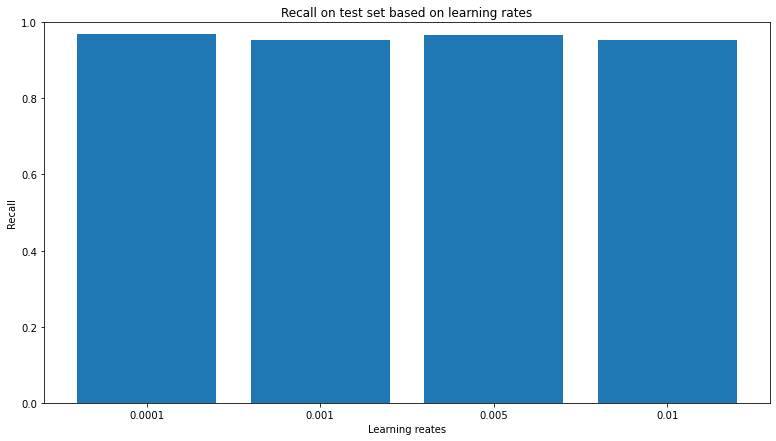

In [ ]:
lrs = [1e-4,1e-3,  5e-3, 1e-2]

# configure to select k features
fs = SelectKBest(score_func=chi2, k=max(10,best_k))

# learn relationship from training data
fs.fit(x_train, y_train)

# transform train input data
X_train_fs = fs.transform(x_train)

# transform test input data
X_val_fs = fs.transform(x_val)

# transform test input data
X_test_fs = fs.transform(X_test)

recalls = []
histories = []
for lr in lrs:
    print("="*10, "lr=%f" % lr, "="*10)
    
    # Using the wrapper for Keras Classifier
    model =KerasClassifier(create_model, 
        lr=lr, 
        verbose=0, 
        epochs=200, 
        validation_data=(X_val_fs, y_val_one_hot), 
        input_shape=X_train_fs.shape[1],
        class_weight=d_class_weights
        )

    # Fitting the model and saving the history.
    history = model.fit(X_train_fs, y_train_one_hot)
    histories.append(history)

    # Making predictions
    y_pred = model.predict(X_test_fs)
    evaluate(y_test, y_pred, "Validation")
    recalls.append(recall_score(y_test, y_pred, average="macro"))

# Plotting recalls for learning rates

plt.figure(figsize=(13,7))
plt.xlabel("Learning reates")
plt.ylabel("Recall")
plt.title("Recall on test set based on learning rates")

plt.bar([str(x) for x in lrs],recalls)

plt.ylim([0,1])
plt.show()

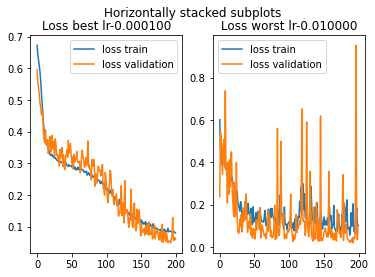

In [ ]:
# Plotting loss curve for best learning rate.

history_best = histories[np.argmax(recalls)]
best_lr = lrs[np.argmax(recalls)]

history_worst = histories[np.argmin(recalls)]
worst_lr = lrs[np.argmin(recalls)]

best_nn = lrs[np.argmax(recalls)]
worst_nn = lrs[np.argmin(recalls)]

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Horizontally stacked subplots')
ax1.set_title("Loss best lr-%f" % (best_lr))
ax1.plot(history_best.history['loss'], label='loss train')
ax1.plot(history_best.history['val_loss'], label='loss validation')
ax1.legend()
ax2.set_title("Loss worst lr-%f" % (worst_lr))
ax2.plot(history_worst.history['loss'], label='loss train')
ax2.plot(history_worst.history['val_loss'], label='loss validation')
ax2.legend()



### 8.2 Testing neurons and hidden layers sizes

In this section, we tweak the number of hidden layers and their sizes.

One can see that the number of hidden layers was not so significant. However, the number of neurons did.

Based on the bar chart below, we can see that smaller number of neurons yields better recall.

The best architecture had 3 hidden layers and 64 neurons each, while the worst architecture had 3 hidden layers, but 256 neurons each.

Finally, smaller number of neurons in the hidden layers produces models with smaller complexity, which is better to analyse and explain.

========== nns=(64, 64) ==========
Confusion Matrix

[[  67    6    0]
 [   2  173    2]
 [  22   97 3059]]

Classification Report

              precision    recall  f1-score   support

     Class 1       0.74      0.92      0.82        73
     Class 2       0.63      0.98      0.76       177
     Class 3       1.00      0.96      0.98      3178

    accuracy                           0.96      3428
   macro avg       0.79      0.95      0.85      3428
weighted avg       0.97      0.96      0.97      3428

========== nns=(128, 128) ==========
Confusion Matrix

[[  64    9    0]
 [   0  174    3]
 [  16   61 3101]]

Classification Report

              precision    recall  f1-score   support

     Class 1       0.80      0.88      0.84        73
     Class 2       0.71      0.98      0.83       177
     Class 3       1.00      0.98      0.99      3178

    accuracy                           0.97      3428
   macro avg       0.84      0.95      0.88      3428
weighted avg       0.98    

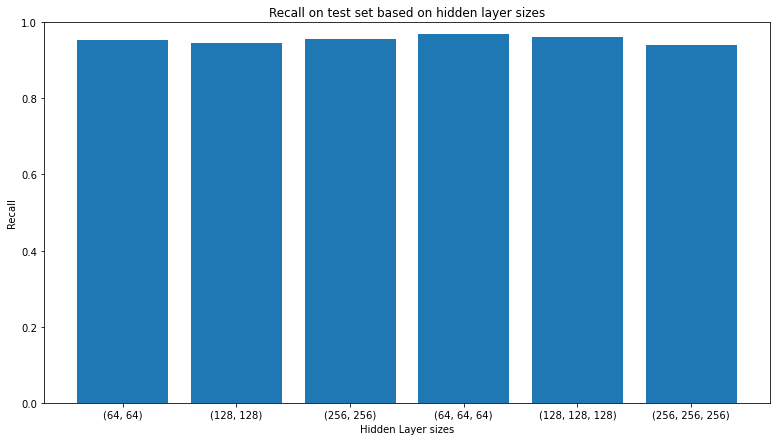

In [ ]:
nns = [(64, 64), (128,128), (256,256), (64,64,64), (128,128,128),(256,256,256) ]

# configure to select k features
fs = SelectKBest(score_func=chi2, k=13)

# learn relationship from training data
fs.fit(x_train, y_train)

# transform train input data
X_train_fs = fs.transform(x_train)

# transform test input data
X_val_fs = fs.transform(x_val)

# transform test input data
X_test_fs = fs.transform(X_test)

recalls_nns = []
histories_nns = []
for nn in nns:
    print("="*10, "nns=%s" % str(nn), "="*10)
    
    # Using the wrapper for Keras Classifier
    model =KerasClassifier(create_model, 
        lr=1e-3,
        hidden_layer_sizes =  nn,
        verbose=0, 
        epochs=200, 
        validation_data=(X_val_fs, y_val_one_hot), 
        input_shape=X_train_fs.shape[1],
        class_weight=d_class_weights
    )

    # Fitting the model and saving the history.
    history = model.fit(X_train_fs, y_train_one_hot)
    histories_nns.append(history)

    # Making predictions
    y_pred = model.predict(X_test_fs)
    evaluate(y_test, y_pred, "Test")
    recalls_nns.append(recall_score(y_test, y_pred, average="macro"))

# Plotting recalls for learning rates

plt.figure(figsize=(13,7))
plt.xlabel("Hidden Layer sizes")
plt.ylabel("Recall")
plt.title("Recall on test set based on hidden layer sizes")

plt.bar([str(x) for x in nns],recalls_nns)

plt.ylim([0,1])
plt.show()

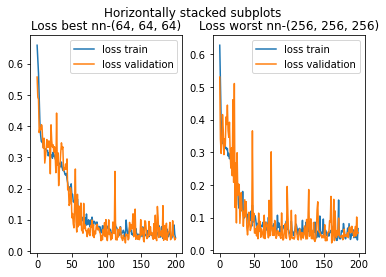

In [ ]:
# Plotting loss curve for best learning rate.

history_best = histories_nns[np.argmax(recalls_nns)]
history_worst = histories_nns[np.argmin(recalls_nns)]

best_nn = nns[np.argmax(recalls_nns)]
worst_nn = nns[np.argmin(recalls_nns)]

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Horizontally stacked subplots')
ax1.set_title("Loss best nn-%s" % str(best_nn))
ax1.plot(history_best.history['loss'], label='loss train')
ax1.plot(history_best.history['val_loss'], label='loss validation')
ax1.legend()
ax2.set_title("Loss worst nn-%s" % str(worst_nn))
ax2.plot(history_worst.history['loss'], label='loss train')
ax2.plot(history_worst.history['val_loss'], label='loss validation')
ax2.legend()



## 8.3 Testing multiple training algorithms

In this section, we test some optimizers.

Based on the best hyperparameters provided in the previous sections, we perform the following tests.

The chart below shows the performance of each optimizer, and Adam was the best in terms of F1-Score.
One can also note that Adadelta was the worst in the other hand. However, when observing the loss curve for such optimizer, one can see underfitting.
Thus, it would required more training steps.

========== opt=adam ==========
Confusion Matrix

[[  70    3    0]
 [   0  175    2]
 [  19   94 3065]]

Classification Report

              precision    recall  f1-score   support

     Class 1       0.79      0.96      0.86        73
     Class 2       0.64      0.99      0.78       177
     Class 3       1.00      0.96      0.98      3178

    accuracy                           0.97      3428
   macro avg       0.81      0.97      0.88      3428
weighted avg       0.98      0.97      0.97      3428

========== opt=sgd ==========
Confusion Matrix

[[  42   15   16]
 [  27  110   40]
 [ 255 1488 1435]]

Classification Report

              precision    recall  f1-score   support

     Class 1       0.13      0.58      0.21        73
     Class 2       0.07      0.62      0.12       177
     Class 3       0.96      0.45      0.61      3178

    accuracy                           0.46      3428
   macro avg       0.39      0.55      0.32      3428
weighted avg       0.90      0.46     

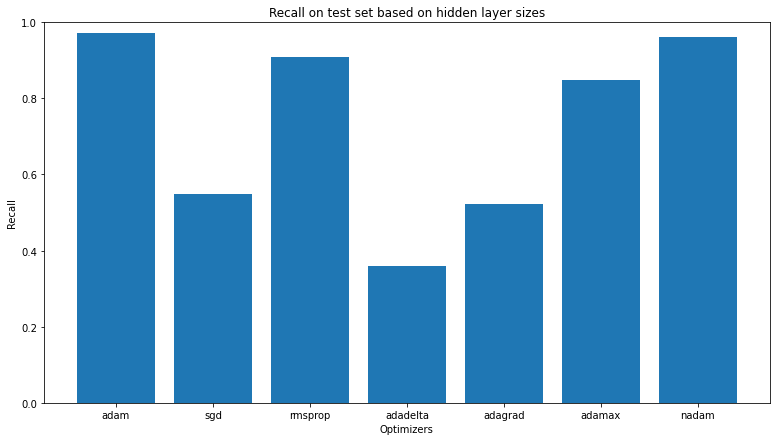

In [ ]:
opts = ['adam', "sgd", "rmsprop", "adadelta", "adagrad","adamax", "nadam"]

# configure to select k features
fs = SelectKBest(score_func=chi2, k=13)

# learn relationship from training data
fs.fit(x_train, y_train)

# transform train input data
X_train_fs = fs.transform(x_train)

# transform test input data
X_val_fs = fs.transform(x_val)

# transform test input data
X_test_fs = fs.transform(X_test)

recalls_opts = []
histories_opts = []

callbacks = [
    keras.callbacks.ModelCheckpoint("checkpoints/thyroid_model_at_epoch_{epoch}.h5"),
    keras.callbacks.EarlyStopping(monitor="val_recall", patience=200, restore_best_weights=True)
]

for opt in opts:
    print("="*10, "opt=%s" % str(opt), "="*10)
    
    # Using the wrapper for Keras Classifier
    model =KerasClassifier(create_model, 
        lr=1e-3,
        hidden_layer_sizes =  (64,64,64),
        verbose=0, 
        epochs=200, 
        opt=opt,
        validation_data=(X_val_fs, y_val_one_hot), 
        input_shape=X_train_fs.shape[1],
        callbacks=callbacks,
        class_weight=d_class_weights
    )

    # Fitting the model and saving the history.
    history = model.fit(X_train_fs, y_train_one_hot)
    histories_opts.append(history)

    # Making predictions
    y_pred = model.predict(X_test_fs)
    evaluate(y_test, y_pred, "Test")
    recalls_opts.append(recall_score(y_test, y_pred, average="macro"))

# Plotting recalls for learning rates

plt.figure(figsize=(13,7))
plt.xlabel("Optimizers")
plt.ylabel("Recall")
plt.title("Recall on test set based on hidden layer sizes")

plt.bar([str(x) for x in opts],recalls_opts)

plt.ylim([0,1])
plt.show()

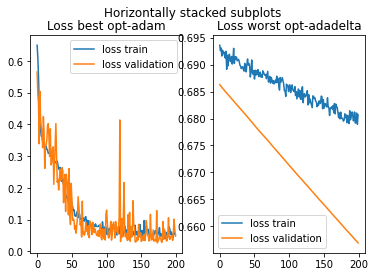

In [ ]:
# Plotting loss curve for best opt.

history_best = histories_opts[np.argmax(recalls_opts)]
history_worst = histories_opts[np.argmin(recalls_opts)]

best_opt = opts[np.argmax(recalls_opts)]
worst_opt = opts[np.argmin(recalls_opts)]

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Horizontally stacked subplots')
ax1.set_title("Loss best opt-%s" % str(best_opt))
ax1.plot(history_best.history['loss'], label='loss train')
ax1.plot(history_best.history['val_loss'], label='loss validation')
ax1.legend()
ax2.set_title("Loss worst opt-%s" % str(worst_opt))
ax2.plot(history_worst.history['loss'], label='loss train')
ax2.plot(history_worst.history['val_loss'], label='loss validation')
ax2.legend()